In [1]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict
from scipy.cluster import hierarchy

%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['axes.grid'] = True
mlp.rcParams['grid.linestyle'] = '--'
mlp.rcParams['xtick.labelsize'] = 12
mlp.rcParams['ytick.labelsize'] = 12
mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['legend.fontsize'] = 12
#mlp.rcParams['axes.xmargin'] = 0.01
mlp.rcParams['font.size'] = 12
mlp.rcParams['figure.figsize'] = (5,5)

mlp.rcParams['xtick.direction'] = 'in'
mlp.rcParams['xtick.major.size'] = 3
mlp.rcParams['xtick.major.width'] = 0.5
mlp.rcParams['xtick.minor.size'] = 1.5
mlp.rcParams['xtick.minor.width'] = 0.5
mlp.rcParams['xtick.minor.visible'] = True
mlp.rcParams['xtick.top'] = True

mlp.rcParams['ytick.direction'] = 'in'
mlp.rcParams['ytick.major.size'] = 3
mlp.rcParams['ytick.major.width'] = 0.5
mlp.rcParams['ytick.minor.size'] = 1.5
mlp.rcParams['ytick.minor.width'] = 0.5
mlp.rcParams['ytick.minor.visible'] = True
mlp.rcParams['ytick.right'] = True

mlp.rcParams['font.family'] = 'serif'
mlp.rcParams['mathtext.fontset'] = 'dejavuserif'

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes

## Load data

In [4]:
with open('../data/comb.pickle', 'rb') as handle:
    data = pickle.load(handle)

df, metadata, features, target, rows = data.values()

In [5]:
comb = df.loc[rows, features + [target]].copy()
comb.reset_index(drop=True, inplace=True)

In [6]:
with open('../data/clustering_results.pickle', 'rb') as handle:
    clustering_results = pickle.load(handle)
    
correlation_matrix, distance_linkage, kolmogorov_smirnov, thresholds, results = clustering_results.values()

## Number of clusters

In [7]:
ZOOM = (0,50)

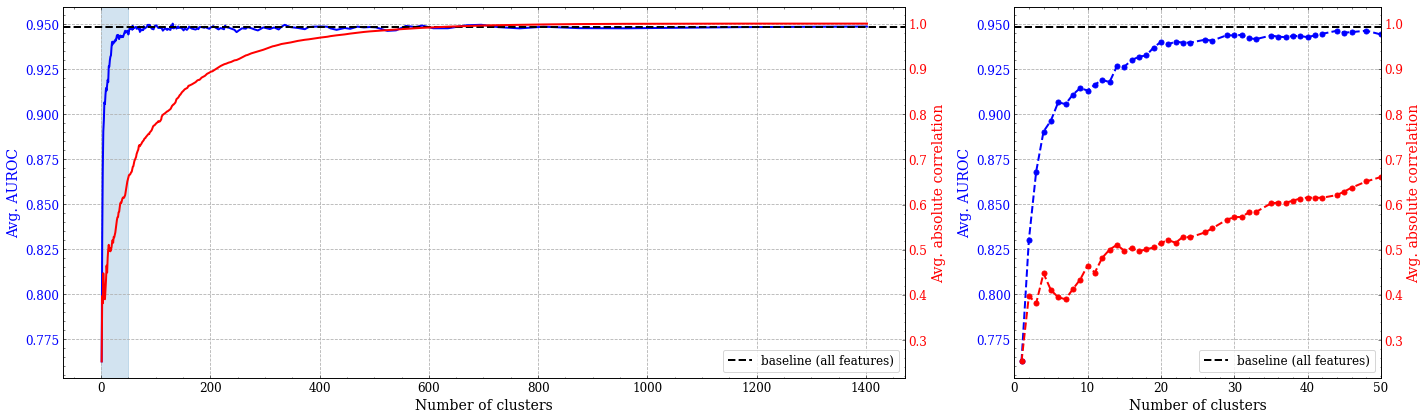

In [8]:
fig = plt.figure(figsize=(20, 6))

ax0 = fig.add_subplot(1,3,(1,2))
results.set_index('clusters_number').auc_mean.plot(ax=ax0, label='', color='blue')
ax0.axhline(0.94862, linestyle='--', color='k', label='baseline (all features)')
ax0.axvspan(ZOOM[0], ZOOM[1], alpha=0.2, color='tab:blue')
ax0.tick_params(axis='y', labelcolor='blue')
ax0.set_xlabel('Number of clusters')
ax0.set_ylabel('Avg. AUROC', color='blue')
ax02 = ax0.twinx()
results.set_index('clusters_number').mean_abs_correlation.plot(ax=ax02, label='', color='red')
ax02.tick_params(axis='y', labelcolor='red')
ax02.set_ylabel('Avg. absolute correlation', color='red')
ax02.grid(False)
ax0.legend()

ax1 = fig.add_subplot(1,3,3)
results.set_index('clusters_number').auc_mean.plot(ax=ax1, label='', linestyle='--', marker='.', markersize=10, color='blue')
ax1.axhline(0.94862, linestyle='--', color='k', label='baseline (all features)')
ax1.set_xlim(ZOOM[0], ZOOM[1])
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Avg. AUROC', color='blue')
ax12 = ax1.twinx()
results.set_index('clusters_number').mean_abs_correlation.plot(ax=ax12, label='', linestyle='--', marker='.', markersize=10, color='red')
ax12.tick_params(axis='y', labelcolor='red')
ax12.set_ylabel('Avg. absolute correlation', color='red')
ax12.grid(False)
ax1.legend()

plt.tight_layout()

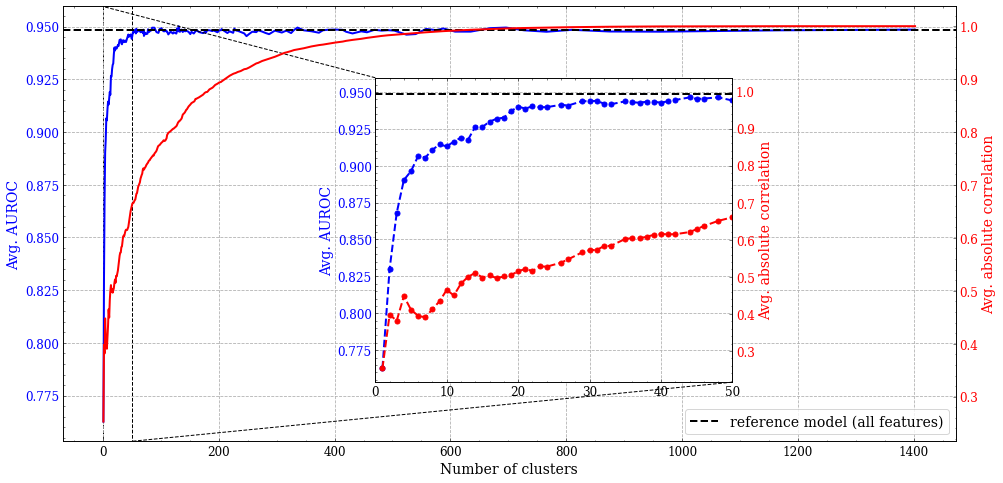

In [9]:
fig = plt.figure(figsize=(16, 8))

ax0 = fig.add_subplot(1,1,1)
results.set_index('clusters_number').auc_mean.plot(ax=ax0, label='', color='blue')#, linestyle='--', marker='.')
ax0.axhline(0.94862, linestyle='--', color='k', label='reference model (all features)')
#ax0.axvspan(ZOOM[0], ZOOM[1], alpha=0.2, color='tab:blue')
ax0.tick_params(axis='y', labelcolor='blue')
ax0.set_xlabel('Number of clusters')
ax0.set_ylabel('Avg. AUROC', color='blue')
ax02 = ax0.twinx()
results.set_index('clusters_number').mean_abs_correlation.plot(ax=ax02, label='', color='red')
ax02.tick_params(axis='y', labelcolor='red')
ax02.set_ylabel('Avg. absolute correlation', color='red')
ax02.grid(False)
ax0.legend(fontsize=14)

zoom_ax = ax0.inset_axes([0.35, 0.136, 0.4, 0.7])
results.set_index('clusters_number').auc_mean.plot(ax=zoom_ax, label='', linestyle='--', marker='.', markersize=10, color='blue')
zoom_ax.axhline(0.94862, linestyle='--', color='k', label='baseline (all features)')
zoom_ax.set_xlim(ZOOM[0], ZOOM[1])
zoom_ax.set_ylim(ax0.get_ylim())
zoom_ax.tick_params(axis='y', labelcolor='blue')
zoom_ax.set_xlabel('')
zoom_ax.set_ylabel('Avg. AUROC', color='blue')
zoom_ax_left = zoom_ax.twinx()
results.set_index('clusters_number').mean_abs_correlation.plot(ax=zoom_ax_left, label='', linestyle='--', marker='.', markersize=10, color='red')
zoom_ax_left.tick_params(axis='y', labelcolor='red')
zoom_ax_left.set_ylabel('Avg. absolute correlation', color='red')
zoom_ax_left.grid(False)
#zoom_ax.legend()
mark_inset(ax0, zoom_ax, loc1=2, loc2=4, fc="none", ec='k', linestyle='--');
#plt.savefig(os.path.join('..', 'images', 'feature_selection.png'), dpi=fig.dpi, bbox_inches='tight')

In [18]:
CLUSTERS_NUMBER = 30

auc = results[results.clusters_number == CLUSTERS_NUMBER]['auc_mean'].values[0]
corr = results[results.clusters_number == CLUSTERS_NUMBER]['mean_abs_correlation'].values[0]
print(f'AUC with selected value of clusters number: {auc:.3f}')
print(f'Average correlation with selected value of clusters number: {corr:.2f}')

AUC with selected value of clusters number: 0.944
Average correlation with selected value of clusters number: 0.57


## Features-clusters visualizations

In [20]:
threshold = list(thresholds.keys())[list(thresholds.values()).index(CLUSTERS_NUMBER)]
cluster_ids = hierarchy.fcluster(distance_linkage, threshold, criterion='distance')
selected_features = []
        
cluster_id_to_feature = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature[cluster_id].append(features[idx])
         
for cluster_id, cluster_features in cluster_id_to_feature.items():
    selected_features.append(kolmogorov_smirnov.loc[cluster_id_to_feature[cluster_id], 'ks'].idxmax())
selected_features.remove('fr_epoxide')

In [21]:
selected_features

['BCUT2D_MRHI',
 'AXp-6dv',
 'piPC4',
 'GATS1d',
 'Kappa3',
 'AATS7i',
 'AATS8i',
 'GATS2v',
 'MATS1v',
 'GATS2m',
 'MATS2s',
 'MATS2d',
 'GATS3dv',
 'GATS4dv',
 'ATSC5c',
 'ATSC5d',
 'GATS6s',
 'ATSC7dv',
 'MPC5',
 'BCUTi-1h',
 'fr_Ndealkylation1',
 'MINssO',
 'MDEC-13',
 'PEOE_VSA8',
 'MINdO',
 'BCUTdv-1l',
 'fr_NH0',
 'naHRing',
 'SlogP_VSA10']

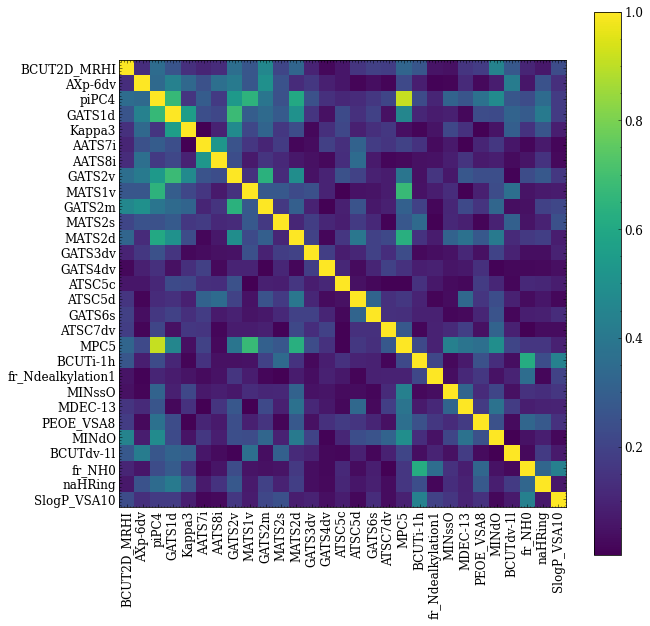

In [22]:
mlp.rcParams['axes.grid'] = False
plt.figure(figsize=(10,10))
im = plt.imshow(correlation_matrix.loc[selected_features, selected_features].abs())
im.axes.set_xticks(np.arange(len(selected_features)))
im.axes.set_xticklabels(selected_features, rotation=90)
im.axes.set_yticks(np.arange(len(selected_features)))
im.axes.set_yticklabels(selected_features, rotation=0)
cbar = plt.colorbar(im);

In [23]:
correlation_matrix.loc[selected_features, selected_features].stack().abs().mean()

0.19813312335624358

In [25]:
clusters_stats = pd.DataFrame(index=range(len(cluster_id_to_feature)), columns=['cluster_id', 'features_number', 'mean_ks', 'std_ks', 'mean_abs_correlation', 'std_abs_correlation'])

for i, (cluster_id, cluster_features) in enumerate(cluster_id_to_feature.items()):
    corr_df_tmp = correlation_matrix.loc[cluster_features, cluster_features].copy()
    clusters_stats.loc[i, 'cluster_id'] = cluster_id
    clusters_stats.loc[i, 'features_number'] = len(cluster_features)
    clusters_stats.loc[i, 'mean_ks'] = kolmogorov_smirnov.loc[cluster_features].mean()[0]
    clusters_stats.loc[i, 'std_ks'] = kolmogorov_smirnov.loc[cluster_features].std(ddof=0)[0]
    clusters_stats.loc[i, 'mean_abs_correlation'] = corr_df_tmp.abs().stack().mean()
    clusters_stats.loc[i, 'std_abs_correlation'] = corr_df_tmp.abs().stack().std(ddof=0)

In [26]:
TOP_K_FEATURES = 5

clusters_stats.sort_values('mean_ks', ascending=False).reset_index(drop=True).head(TOP_K_FEATURES)

,cluster_id,features_number,mean_ks,std_ks,mean_abs_correlation,std_abs_correlation
0,4,91,0.314551,0.073438,0.647958,0.212939
1,2,354,0.272582,0.059477,0.891867,0.082062
2,27,87,0.232415,0.095038,0.539124,0.223118
3,3,45,0.197781,0.05926,0.727433,0.18818
4,16,29,0.187801,0.086505,0.550831,0.20855


In [27]:
LIMIT = 30
PATH = f'../images/clusters_{CLUSTERS_NUMBER}'

top_clusters = clusters_stats.sort_values('mean_ks', ascending=False).reset_index(drop=True).head(TOP_K_FEATURES).cluster_id.to_list()


Path(PATH).mkdir(parents=True, exist_ok=True)
mlp.rcParams['axes.grid'] = True

for c_id in top_clusters:
    cluster_features = cluster_id_to_feature[c_id]
    cluster_features = kolmogorov_smirnov.loc[cluster_features].sort_values('ks', ascending=False).index.to_list()
    if len(cluster_features) > LIMIT:
        cluster_features = cluster_features[:LIMIT]
    n_columns=5
    n_rows=int(np.ceil(len(cluster_features)/n_columns))
    indices = list(itertools.product(list(range(n_rows)), list(range(n_columns))))

    fig, axes = plt.subplots(n_rows, n_columns, sharex=False, sharey=False, figsize=(25, n_rows*5))

    for i, idx in enumerate(indices):
        try:
            col = cluster_features[i]
            sns.histplot(data=comb, x=col, hue=target, kde=True, stat='density', edgecolor='white', linewidth=0, alpha=0.4, line_kws=dict(linewidth=3), ax=axes[idx])
            axes[idx].title.set_text('Kolmogorov-Smirnov: {ks:.3f}'.format(ks=kolmogorov_smirnov.loc[col, 'ks']))
        except:
            pass

    add_subplot_border(axes[0,0], 1, 'r')

    plt.tight_layout()
    fig.savefig(os.path.join(PATH, f'cluster_id_{c_id}.png'), dpi=fig.dpi)
    plt.close(fig)

## Scatterplot

In [28]:
x1 = 'piPC4'
x2 = 'GATS1d'

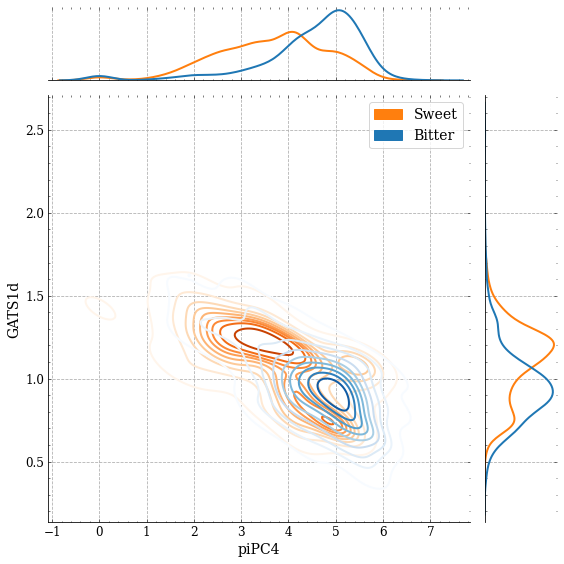

In [29]:
g = sns.JointGrid(x=x1, y=x2, data=comb, height=8)

comb0 = comb[comb[target] == 'Sweet'].copy()
comb1 = comb[comb[target] == 'Bitter'].copy()

sns.kdeplot(x=x1, y=x2, data=comb0, cmap='Oranges', shade=False, thresh=0.05, ax=g.ax_joint, linestyles='-')
sns.kdeplot(x=x1, y=x2, data=comb1, cmap='Blues', shade=False, thresh=0.05, ax=g.ax_joint, linestyles='-')
sns.kdeplot(x=x1, data=comb0, color='tab:orange', legend=False, ax=g.ax_marg_x, linestyle='-')
sns.kdeplot(x=x1, data=comb1, color='tab:blue', legend=False, ax=g.ax_marg_x, linestyle='-')
sns.kdeplot(y=x2, data=comb0, color='tab:orange', legend=False, ax=g.ax_marg_y, linestyle='-')
sns.kdeplot(y=x2, data=comb1, color='tab:blue', legend=False, ax=g.ax_marg_y, linestyle='-')

legend_properties = {'size':14}
l1 = mpatches.Patch(color='tab:orange', label='Sweet')
l2 = mpatches.Patch(color='tab:blue', label='Bitter')
g.ax_joint.legend(handles=[l1, l2], prop=legend_properties);